# <center> PGM Project</center>
## <center>Dirichlet Process Mixture Models</center>



---


*   Mohammad POUL DOUST
*   Andrei MARDALE
*   Etienne EKPO
*   Laetitia COUGE



# Preparing Environment 



In [0]:
# Install PYro
!pip install http://download.pytorch.org/whl/cpu/torch-0.4.0-cp27-cp27mu-linux_x86_64.whl 
!pip install pyro-ppl

In [0]:
#imports

import torch
from torch.distributions import constraints
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

from pyro.distributions import *
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive
assert pyro.__version__.startswith('1')
pyro.enable_validation(True)       # can help with debugging
pyro.set_rng_seed(0)
from IPython.display import Math, HTML

# Airbus
from collections import Counter

import pandas as pd
import numpy as np

import h5py

from scipy.special import expit
from scipy.spatial import distance

import pywt
import scipy

from sklearn.preprocessing import StandardScaler,RobustScaler, MinMaxScaler
from sklearn.decomposition.pca import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold.t_sne import TSNE
from sklearn.cluster import DBSCAN

# from metric_learn import LMNN

from sklearn.model_selection import train_test_split
import seaborn as sns

%tensorflow_version 1.x
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, Reshape, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, optimizers

import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Datasets
!wget 'https://defi-ia.insa-toulouse.fr/static/data/train.hdf5' --no-check-certificate
!wget 'https://defi-ia.insa-toulouse.fr/static/data/validation.hdf5' --no-check-certificate
!wget 'https://defi-ia.insa-toulouse.fr/static/data/test.hdf5' --no-check-certificate

--2020-01-24 22:12:18--  https://defi-ia.insa-toulouse.fr/static/data/train.hdf5
Resolving defi-ia.insa-toulouse.fr (defi-ia.insa-toulouse.fr)... 195.83.9.100
Connecting to defi-ia.insa-toulouse.fr (defi-ia.insa-toulouse.fr)|195.83.9.100|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 825280760 (787M) [application/octet-stream]
Saving to: ‘train.hdf5’

train.hdf5          100%[===================>] 787.05M  24.9MB/s    in 33s     

2020-01-24 22:12:51 (24.1 MB/s) - ‘train.hdf5’ saved [825280760/825280760]

--2020-01-24 22:12:52--  https://defi-ia.insa-toulouse.fr/static/data/validation.hdf5
Resolving defi-ia.insa-toulouse.fr (defi-ia.insa-toulouse.fr)... 195.83.9.100
Connecting to defi-ia.insa-toulouse.fr (defi-ia.insa-toulouse.fr)|195.83.9.100|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 292955936 (279M) [application/octet-stream]

# Data Processing

In [0]:
# Helpers
def load_dataset(train_path, valid_path, test_path):
    with h5py.File(train_path, 'r') as f:
        a_group_key = list(f.keys())[0]
        group = f[a_group_key]
        
        data = group["block0_values"][()]
        train_data = data
    
    with h5py.File(valid_path, 'r') as f:
        a_group_key = list(f.keys())[0]
        group = f[a_group_key]
        
        data = group["block0_values"][()]
        valid_data = data
        
    with h5py.File(test_path, 'r') as f:
        a_group_key = list(f.keys())[0]
        group = f[a_group_key]
        
        data = group["block0_values"][()]
        test_data = data
    
    return train_data, valid_data, test_data
  
def aggregate_by_mean(X_train, X_valid, X_test):
    X_train_agg = np.mean(X_train.reshape((X_train.shape[0], 12288, 5)), axis = 2)
    X_valid_agg = np.mean(X_valid.reshape((X_valid.shape[0], 12288, 5)), axis = 2)
    X_test_agg = np.mean(X_test.reshape((X_test.shape[0], 12288, 5)), axis = 2)
  
    return X_train_agg, X_valid_agg, X_test_agg


def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy


def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics


def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]




In [0]:
# Load Data
X_train, X_validation, X_test  = load_dataset('train.hdf5', 'validation.hdf5', 'test.hdf5')
X_train_agg, X_valid_agg, X_test_agg = aggregate_by_mean(X_train, X_validation, X_test)

print(X_train_agg.shape)
print(X_valid_agg.shape)
print(X_test_agg.shape)

(1677, 12288)
(594, 12288)
(1917, 12288)


In [0]:
# Features Extraction
x_t = np.array(get_features_ab(X_train_agg, 'bior6.8'))
x_v = np.array(get_features_ab(X_valid_agg, 'bior6.8'))
x_tst = np.array(get_features_ab(X_test_agg, 'bior6.8'))

In [0]:
# scaling
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_t)
x_valid_scaled = scaler.transform(x_v)
x_test_scaled = scaler.transform(x_tst)


# Tsne Embedding:

In [0]:
x_train_valid = np.concatenate((x_train_scaled, x_valid_scaled), axis=0)
y_train_valid = np.concatenate((np.ones(x_train_scaled.shape[0]), np.zeros(x_valid_scaled.shape[0])), axis=0)
X_embedded_train_valid = TSNE(n_components=2).fit_transform(x_train_valid)


# Pyro - Dirichlet Process Mixture Models

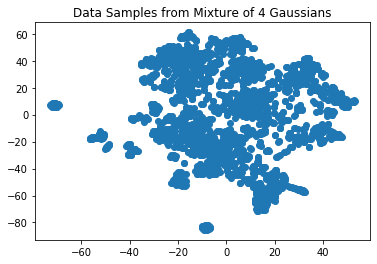

In [0]:
data = torch.tensor(X_embedded_train_valid)

plt.scatter(data[:, 0], data[:, 1])
plt.title("Data Samples from Mixture of 4 Gaussians")
plt.show()
N = data.shape[0]
# print(data)

In [0]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

In [0]:
display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/"
               "latest.js?config=default'></script>"))

Math(r'\pi_{i}\left(\beta_{1: \infty}\right)=\beta_{i} \prod_{j<i}\left(1-\beta_{j}\right)')

<IPython.core.display.Math object>

In [0]:
def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha))

    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", MultivariateNormal(torch.zeros(2), 5 * torch.eye(2)))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta)))
        pyro.sample("obs", MultivariateNormal(mu[z], torch.eye(2)), obs=data)

In [0]:
def guide(data):
    kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda: MultivariateNormal(torch.zeros(2), 3 * torch.eye(2)).sample([T]))
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
        q_mu = pyro.sample("mu", MultivariateNormal(tau, torch.eye(2)))

    # with pyro.plate("sigma_plate", T):
    #     sigma = pyro.sample("sigma", InverseWishart(lamda0**-1, niu0))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(phi))

100%|██████████| 1000/1000 [01:26<00:00, 10.07it/s]


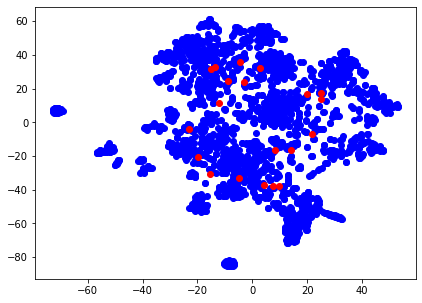

In [0]:
T = 20
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

def train(num_iterations):
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(data)
        losses.append(loss)

def truncate(alpha, centers, weights):
    threshold = alpha**-1 / 100.
    true_centers = centers[weights > threshold]
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_centers, true_weights

alpha = 50
train(1000)

# We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
Bayes_Centers_01, Bayes_Weights_01 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

# alpha = 1.5
# train(1000)

# # We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
# Bayes_Centers_15, Bayes_Weights_15 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_01[:, 0], Bayes_Centers_01[:, 1], color="red")

# plt.subplot(1, 2, 2)
# plt.scatter(data[:, 0], data[:, 1], color="blue")
# # plt.scatter(Bayes_Centers_15[:, 0], Bayes_Centers_15[:, 1], color="red")
# plt.tight_layout()
plt.show()